In [48]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
import lightgbm as lgb
from collections import Counter
import warnings
import pickle
from catboost import CatBoostClassifier
warnings.filterwarnings("ignore")

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns       

import boto3
from botocore.client import Config
from io import StringIO

from scipy import stats
from scipy.stats import  norm
from sklearn.preprocessing import StandardScaler
import warnings
%matplotlib inline  

# 特征处理1

In [50]:
#填充缺失值
def fill_missings(res):

    res['Alley'] = res['Alley'].fillna('missing')
    res['PoolQC'] = res['PoolQC'].fillna(res['PoolQC'].mode()[0])
    res['MasVnrType'] = res['MasVnrType'].fillna('None')
    res['BsmtQual'] = res['BsmtQual'].fillna(res['BsmtQual'].mode()[0])
    res['BsmtCond'] = res['BsmtCond'].fillna(res['BsmtCond'].mode()[0])
    res['FireplaceQu'] = res['FireplaceQu'].fillna(res['FireplaceQu'].mode()[0])
    res['GarageType'] = res['GarageType'].fillna('missing')
    res['GarageFinish'] = res['GarageFinish'].fillna(res['GarageFinish'].mode()[0])
    res['GarageQual'] = res['GarageQual'].fillna(res['GarageQual'].mode()[0])
    res['GarageCond'] = res['GarageCond'].fillna('missing')
    res['Fence'] = res['Fence'].fillna('missing')
    res['Street'] = res['Street'].fillna('missing')
    res['LotShape'] = res['LotShape'].fillna('missing')
    res['LandContour'] = res['LandContour'].fillna('missing')
    res['BsmtExposure'] = res['BsmtExposure'].fillna(res['BsmtExposure'].mode()[0])
    res['BsmtFinType1'] = res['BsmtFinType1'].fillna('missing')
    res['BsmtFinType2'] = res['BsmtFinType2'].fillna('missing')
    res['CentralAir'] = res['CentralAir'].fillna('missing')
    res['Electrical'] = res['Electrical'].fillna(res['Electrical'].mode()[0])
    res['MiscFeature'] = res['MiscFeature'].fillna('missing')
    res['MSZoning'] = res['MSZoning'].fillna(res['MSZoning'].mode()[0])    
    res['Utilities'] = res['Utilities'].fillna('missing')
    res['Exterior1st'] = res['Exterior1st'].fillna(res['Exterior1st'].mode()[0])
    res['Exterior2nd'] = res['Exterior2nd'].fillna(res['Exterior2nd'].mode()[0])    
    res['KitchenQual'] = res['KitchenQual'].fillna(res['KitchenQual'].mode()[0])
    res["Functional"] = res["Functional"].fillna("Typ")
    res['SaleType'] = res['SaleType'].fillna(res['SaleType'].mode()[0])
 #   res['SaleCondition'] = res['SaleCondition'].fillna('missing')
    #数值型变量的空值先用0值替换
    flist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                     'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                     'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                     'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                     'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
    for fl in flist:
        res[fl] = res[fl].fillna(0)
    #0值替换   
    res['TotalBsmtSF'] = res['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    res['2ndFlrSF'] = res['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    res['GarageArea'] = res['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    res['GarageCars'] = res['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
    res['LotFrontage'] = res['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
    res['MasVnrArea'] = res['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
    res['BsmtFinSF1'] = res['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)    
    res['MSSubClass'] = res['MSSubClass'].apply(str)
    res['YrSold'] = res['YrSold'].astype(str)
    res['MoSold'] = res['MoSold'].astype(str)
    res['OverallCond'] = res['OverallCond'].astype(str)
    return res

In [79]:
kaggle_test = pd.read_csv('test.csv')
kaggle_train = pd.read_csv('train.csv')

# 数据分析

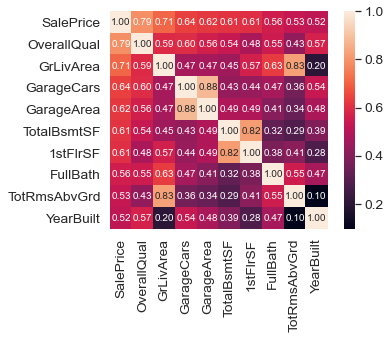

In [80]:
corrmat = kaggle_train.corr()
k  = 10 # 关系矩阵中将显示10个特征
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(kaggle_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, \
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [81]:
df_na = (kaggle_train.isnull().sum() / len(kaggle_train)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'缺失率': df_na})
missing_data.head(15)

,缺失率
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


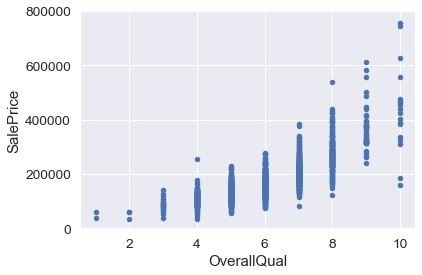

In [82]:
var  = 'OverallQual'
data = pd.concat([kaggle_train['SalePrice'], kaggle_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


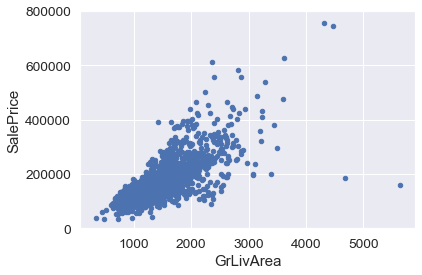

In [83]:
var  = 'GrLivArea'
data = pd.concat([kaggle_train['SalePrice'], kaggle_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


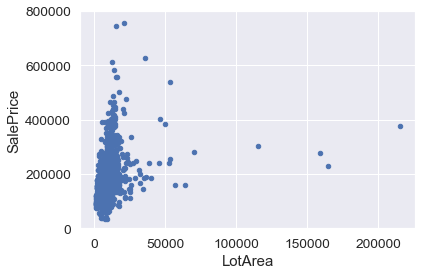

In [84]:
var  = 'LotArea'
data = pd.concat([kaggle_train['SalePrice'], kaggle_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

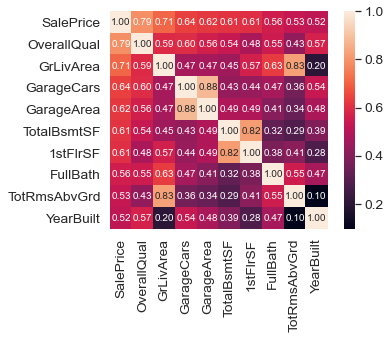

In [85]:
k  = 10 # 关系矩阵中将显示10个特征
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(kaggle_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, \
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# 特征处理1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021B5DB173D0>,
      dtype=object)

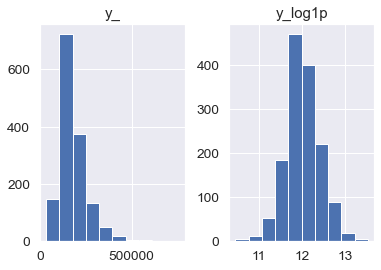

In [86]:

kaggle_test = fill_missings(kaggle_test)
kaggle_train = fill_missings(kaggle_train)

df_y=pd.DataFrame({'y_':kaggle_train.SalePrice,'y_log1p':np.log1p(kaggle_train.SalePrice)})
df_y.hist()


#kaggle_train = fill_missings1(kaggle_train)
# y=data_train.pop('SalePrice')

# 特征处理2

In [87]:
y=kaggle_train.pop('SalePrice')
all_data=pd.concat((kaggle_train,kaggle_test),axis=0)
all_data.shape 
# MSSubClass 是一个等级标签，属于category ,将其变为str类型
print('MSSubClass.type:',all_data.MSSubClass.dtypes)
all_data.MSSubClass=all_data.MSSubClass.astype(str)
all_data.MSSubClass.value_counts() #统计个数

#处理所有类别变量
cnt_data=pd.get_dummies(all_data)
cnt_data.head()

MSSubClass.type: object


,Id,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,7,2003,2003,196.00000,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
1,2,80.0,9600,6,1976,1976,54.59815,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
2,3,68.0,11250,7,2001,2002,162.00000,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
3,4,60.0,9550,7,1915,1970,54.59815,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
4,5,84.0,14260,8,2000,2000,350.00000,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


In [88]:
#将空值降序排列
cnt_data.isnull().sum().sort_values(ascending=False).head()
#用平均值填满空值
cols_mean=cnt_data.mean()
cnt_data=cnt_data.fillna(cols_mean)
cnt_data.isnull().sum().sum()

0

In [89]:
#取出所有numerical的变量
numerical_cols=cnt_data.columns[cnt_data.dtypes != 'object']

numerical_cols_mean=cnt_data.loc[:,numerical_cols].mean()
numerical_cols_std=cnt_data.loc[:,numerical_cols].std()
cnt_data.loc[:,numerical_cols]=(cnt_data.loc[:,numerical_cols]-numerical_cols_mean)/numerical_cols_std

In [90]:
kaggle_test.shape

(1459, 80)

In [91]:
x_train=cnt_data.iloc[0:1460,:]
x_test=cnt_data.iloc[1460:2919,:]
x_train.shape

(1460, 335)

# 岭回归

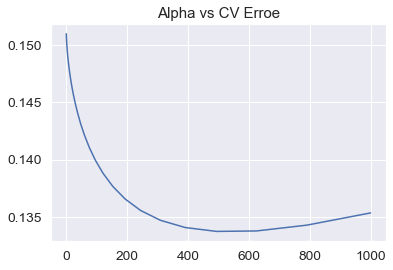

In [92]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score #划分数据，交叉验证
import matplotlib.pyplot as plt
%matplotlib inline

y_train=df_y.y_log1p
x_train=x_train.values
x_test=x_test.values

#将DataFrame数据转成Numpy Array数据，与sklearn相匹配

#尝试调参
alphas=np.logspace(-2,3,50)# 0.01~1000
test_scores=[]
for alpha in alphas:
    clf=Ridge(alpha)
    test_score=np.sqrt(-cross_val_score(clf,x_train,y_train,cv=10,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

plt.plot(alphas,test_scores)
plt.title('Alpha vs CV Erroe')
plt.show()

# 随机森林回归

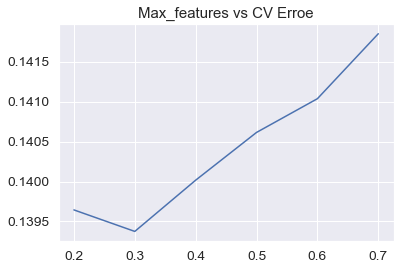

In [95]:
from sklearn.ensemble import RandomForestRegressor


max_features=[.2,.3,.4,.5,.6,.7]
test_scores=[]
for max_feature in max_features :
    rlf=RandomForestRegressor(n_estimators=200,max_features=max_feature)
    test_score=np.sqrt(-cross_val_score(rlf,x_train,y_train,cv=5,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(max_features,test_scores)
plt.title('Max_features vs CV Erroe')
plt.show()

# 模型融合

In [65]:
ridge=Ridge(alpha=400)
rlf=RandomForestRegressor(max_features=0.3)

ridge.fit(x_train,y_train)
rlf.fit(x_train,y_train)

y_ridge=np.expm1(ridge.predict(x_test))
y_rlf=np.expm1(rlf.predict(x_test))

y_en=(y_ridge+y_rlf)/2 

In [66]:
submission_df=pd.DataFrame({'Id':kaggle_test.Id,'SalePrice':y_en})

In [67]:
submission_df

,Id,SalePrice
0,1461,123846.409461
1,1462,156318.956147
2,1463,179355.315314
3,1464,188806.997322
4,1465,193119.103784
...,...,...
1454,2915,85012.280251
1455,2916,85382.174518
1456,2917,157541.610670
1457,2918,112047.551474


# 连接并上传至S3

In [68]:
access_key = 'AA558F851A9B6DADEEA4'
secret_key = 'WzAyNkMyNTQ3MEIzMDJDNTg0RjUzQjM0MUQ4OUEy'
host = 'http://scut.depts.bingosoft.net:29997'

s3 = boto3.client('s3',
    
    aws_access_key_id=access_key,
    aws_secret_access_key=secret_key,
    endpoint_url=host,
                  
   config=Config(signature_version='s3'),
    region_name='cn-north-1',)

In [96]:
submission_df.to_csv('result.csv', index=False)
s3.put_object(Bucket = 'libin',Body='df.csv', Key='result/res.csv', ACL='public-read')

{'ResponseMetadata': {'RequestId': 'tx00000000000000004fb8c-0060d448e6-10af8060-default',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-length': '0',
   'etag': '"fc18a619f8dc5643b0b06af2c19e19d1"',
   'accept-ranges': 'bytes',
   'x-amz-version-id': 'JW0OHtalzPDc1bOpjHSEXvLPUKvLXhT',
   'server': 'BingoCloudS3 2.2.0',
   'x-amz-request-id': 'tx00000000000000004fb8c-0060d448e6-10af8060-default',
   'date': 'Thu, 24 Jun 2021 08:57:10 GMT',
   'connection': 'Keep-Alive'},
  'RetryAttempts': 0},
 'ETag': '"fc18a619f8dc5643b0b06af2c19e19d1"',
 'VersionId': 'JW0OHtalzPDc1bOpjHSEXvLPUKvLXhT'}